In [1]:
import pickle
import torch
import copy
import random

import numpy as np
import pandas as pd
import torch.nn as nn
import torchvision.models as models


from skimage import io
from tqdm import tqdm, tqdm_notebook
from PIL import Image
from pathlib import Path
from torchvision import transforms
from sklearn.metrics import f1_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from matplotlib import colors, pyplot as plt

%matplotlib inline

train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')
torch.cuda.is_available()

CUDA is available!  Training on GPU ...


True

In [2]:
SEED = 69

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

DATA_MODES = ['train', 'val', 'test']
RESCALE_SIZE = 224
DEVICE = torch.device("cuda")
EPOCHS=24
BATCH_SIZE=64

In [3]:
class SimpsonsDataset(Dataset):
    """
    Датасет с картинками, который паралельно подгружает их из папок
    производит скалирование и превращение в торчевые тензоры
    """
    def __init__(self, files, mode):
        super().__init__()
        # список файлов для загрузки
        self.files = sorted(files)
        # режим работы
        self.mode = mode

        if self.mode not in DATA_MODES:
            print(f"{self.mode} is not correct; correct modes: {DATA_MODES}")
            raise NameError

        self.len_ = len(self.files)
     
        self.label_encoder = LabelEncoder()

        if self.mode != 'test':
            self.labels = [path.parent.name for path in self.files]
            self.label_encoder.fit(self.labels)

            with open('label_encoder.pkl', 'wb') as le_dump_file:
                  pickle.dump(self.label_encoder, le_dump_file)
                      
    def __len__(self):
        return self.len_
      
    def load_sample(self, file):
        image = Image.open(file)
        image.load()
        return image
  
    def __getitem__(self, index):
        transform_list = []
        transform_list.append(transforms.Resize((RESCALE_SIZE, RESCALE_SIZE)))
        if self.mode != 'test':            
            transform_list.append(transforms.RandomHorizontalFlip())
            transform_list.append(transforms.RandomRotation(15))
        transform_list.append(transforms.ToTensor())
        transform_list.append(transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5]))

        transform = transforms.Compose(transform_list)
        x = self.load_sample(self.files[index])
        x = transform(x)
        if self.mode == 'test':
            return x
        else:
            label = self.labels[index]
            label_id = self.label_encoder.transform([label])
            y = label_id.item()
            return x, y

In [4]:
def imshow(inp, title=None, plt_ax=plt, default=False):
    """Imshow для тензоров"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

In [5]:
TRAIN_DIR = Path('train/simpsons_dataset')
TEST_DIR = Path('testset/testset')

train_val_files = sorted(list(TRAIN_DIR.rglob('*.jpg')))
test_files = sorted(list(TEST_DIR.rglob('*.jpg')))
train_val_labels = [path.parent.name for path in train_val_files]

In [6]:
def create_dct_path_labels(train_files, train_labels):
    dct_simpsons = {}
    for label_i in np.unique(train_labels).tolist():
        dct_simpsons[label_i] = []

    for path_i, label_i in zip(train_files, train_labels):
        dct_simpsons[label_i].append(path_i)

    return dct_simpsons

In [7]:
dct_path_train = create_dct_path_labels(train_val_files, train_val_labels)

for person in dct_path_train:
    if len(dct_path_train[person]) < 100:
        dct_path_train[person] = dct_path_train[person] * (100 // len(dct_path_train[person]))
        dct_path_train[person].extend(dct_path_train[person][:100 - len(dct_path_train[person])])
        
train_val_files = []
for person in dct_path_train:
    train_val_files.extend(dct_path_train[person])

train_val_labels = [path.parent.name for path in train_val_files]
train_files, val_files = train_test_split(train_val_files, test_size=0.25, \
                                          stratify=train_val_labels)

val_dataset = SimpsonsDataset(val_files, mode='val')

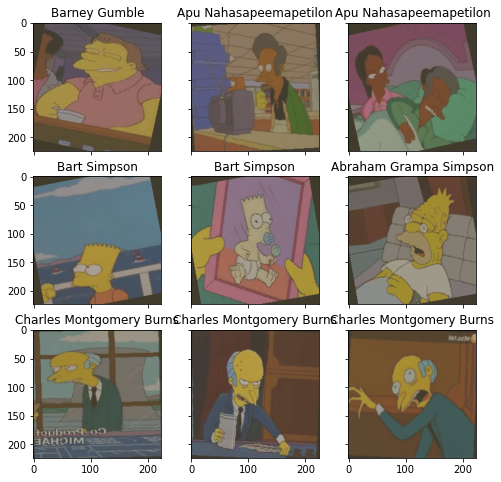

In [8]:
fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(8, 8), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)

In [9]:
def fit_epoch(model, train_loader, criterion, optimizer):
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0
  
    for inputs, labels in train_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        preds = torch.argmax(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_data += inputs.size(0)
              
    train_loss = running_loss / processed_data
    train_acc = running_corrects.cpu().numpy() / processed_data
    return train_loss, train_acc

def eval_epoch(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    processed_size = 0

    for inputs, labels in val_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            preds = torch.argmax(outputs, 1)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_size += inputs.size(0)
    val_loss = running_loss / processed_size
    val_acc = running_corrects.double() / processed_size
    return val_loss, val_acc

def train(train_files, val_files, model, epochs, batch_size):
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"

    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        opt = torch.optim.AdamW(model.parameters())
        criterion = nn.CrossEntropyLoss()
        #scheduler = torch.optim.lr_scheduler.StepLR(opt, step_size=7, gamma=0.1)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            opt, mode='max', factor=0.1, patience=10, verbose=False)
        best_acc = 0.0
        
        for epoch in range(epochs):
            train_loss, train_acc = fit_epoch(model, train_loader, criterion, opt)
            print("loss", train_loss)            
            val_loss, val_acc = eval_epoch(model, val_loader, criterion)
            history.append((train_loss, train_acc, val_loss, val_acc))            
            scheduler.step(val_acc)            
            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                           v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))            
            if val_acc > best_acc:
                best_model_wghts = copy.deepcopy(model.state_dict())
                torch.save(best_model_wghts, './my_submit.mdl')
                best_acc = val_acc
    print(best_acc)        
    return history

def predict(model, test_loader):
    with torch.no_grad():
        logits = []
    
        for inputs in test_loader:
            inputs = inputs.to(DEVICE)
            model.eval()
            outputs = model(inputs).cpu()
            logits.append(outputs)
            
    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    return probs

In [10]:
if val_dataset is None:
    val_dataset = SimpsonsDataset(val_files, mode='val')
    
train_dataset = SimpsonsDataset(train_files, mode='train')
n_classes = len(np.unique(train_val_labels))

In [11]:
model = models.resnet18(pretrained=False)    
model.fc = nn.Linear(in_features=model.fc.in_features, out_features=n_classes)
model = model.to('cuda')

In [12]:
history = train(train_dataset, val_dataset, model=model, epochs=EPOCHS, batch_size=BATCH_SIZE)

epoch:   0%|                                                                                    | 0/24 [00:00<?, ?it/s]

loss 1.971875262463779


epoch:   4%|███▏                                                                       | 1/24 [01:52<43:00, 112.18s/it]


Epoch 001 train_loss: 1.9719     val_loss 1.7568 train_acc 0.4735 val_acc 0.5356
loss 2.95760557229585


epoch:   8%|██████▎                                                                    | 2/24 [03:41<40:47, 111.26s/it]


Epoch 002 train_loss: 2.9576     val_loss 2.2821 train_acc 0.1887 val_acc 0.3838
loss 1.7561162043881424


epoch:  12%|█████████▍                                                                 | 3/24 [05:30<38:42, 110.59s/it]


Epoch 003 train_loss: 1.7561     val_loss 1.4426 train_acc 0.5198 val_acc 0.6033
loss 1.1742690980561508


epoch:  17%|████████████▌                                                              | 4/24 [07:19<36:43, 110.19s/it]


Epoch 004 train_loss: 1.1743     val_loss 1.0989 train_acc 0.6710 val_acc 0.6983
loss 0.8349910297845509


epoch:  21%|███████████████▋                                                           | 5/24 [09:08<34:47, 109.87s/it]


Epoch 005 train_loss: 0.8350     val_loss 0.7817 train_acc 0.7655 val_acc 0.7778
loss 0.6502728136182013


epoch:  25%|██████████████████▊                                                        | 6/24 [10:58<32:55, 109.74s/it]


Epoch 006 train_loss: 0.6503     val_loss 0.6348 train_acc 0.8155 val_acc 0.8233
loss 0.5231847097079927


epoch:  29%|█████████████████████▉                                                     | 7/24 [12:47<31:03, 109.62s/it]


Epoch 007 train_loss: 0.5232     val_loss 0.5459 train_acc 0.8495 val_acc 0.8463
loss 0.4277220618541452


epoch:  33%|█████████████████████████                                                  | 8/24 [14:36<29:11, 109.45s/it]


Epoch 008 train_loss: 0.4277     val_loss 0.4800 train_acc 0.8765 val_acc 0.8664
loss 0.3536822540637309


epoch:  38%|████████████████████████████▏                                              | 9/24 [16:25<27:20, 109.39s/it]


Epoch 009 train_loss: 0.3537     val_loss 0.4608 train_acc 0.8958 val_acc 0.8732
loss 0.3070138367948792


epoch:  42%|██████████████████████████████▊                                           | 10/24 [18:14<25:28, 109.19s/it]


Epoch 010 train_loss: 0.3070     val_loss 0.4297 train_acc 0.9095 val_acc 0.8896
loss 0.2586183505616753


epoch:  46%|█████████████████████████████████▉                                        | 11/24 [20:03<23:38, 109.15s/it]


Epoch 011 train_loss: 0.2586     val_loss 0.4194 train_acc 0.9216 val_acc 0.8942
loss 0.22326484346331674


epoch:  50%|█████████████████████████████████████                                     | 12/24 [21:52<21:49, 109.11s/it]


Epoch 012 train_loss: 0.2233     val_loss 0.5014 train_acc 0.9307 val_acc 0.8704
loss 0.2058458572711445


epoch:  54%|████████████████████████████████████████                                  | 13/24 [23:41<20:00, 109.14s/it]


Epoch 013 train_loss: 0.2058     val_loss 0.4205 train_acc 0.9378 val_acc 0.9024
loss 0.1722207936396731


epoch:  58%|███████████████████████████████████████████▏                              | 14/24 [25:31<18:12, 109.24s/it]


Epoch 014 train_loss: 0.1722     val_loss 0.3644 train_acc 0.9467 val_acc 0.9073
loss 0.1498303403568965


epoch:  62%|██████████████████████████████████████████████▎                           | 15/24 [27:20<16:22, 109.19s/it]


Epoch 015 train_loss: 0.1498     val_loss 0.4317 train_acc 0.9542 val_acc 0.8975
loss 0.1436442536785586


epoch:  67%|█████████████████████████████████████████████████▎                        | 16/24 [29:09<14:33, 109.16s/it]


Epoch 016 train_loss: 0.1436     val_loss 0.4582 train_acc 0.9568 val_acc 0.8913
loss 0.12615646996362032


epoch:  71%|████████████████████████████████████████████████████▍                     | 17/24 [30:58<12:43, 109.12s/it]


Epoch 017 train_loss: 0.1262     val_loss 0.3741 train_acc 0.9597 val_acc 0.9105
loss 0.11219496217000569


epoch:  75%|███████████████████████████████████████████████████████▌                  | 18/24 [32:47<10:54, 109.07s/it]


Epoch 018 train_loss: 0.1122     val_loss 0.3740 train_acc 0.9676 val_acc 0.9139
loss 0.10020139101918808


epoch:  79%|██████████████████████████████████████████████████████████▌               | 19/24 [34:36<09:05, 109.09s/it]


Epoch 019 train_loss: 0.1002     val_loss 0.4332 train_acc 0.9693 val_acc 0.9106
loss 0.1043764162782558


epoch:  83%|█████████████████████████████████████████████████████████████▋            | 20/24 [36:25<07:16, 109.14s/it]


Epoch 020 train_loss: 0.1044     val_loss 0.4355 train_acc 0.9679 val_acc 0.9077
loss 0.0978932091349834


epoch:  88%|████████████████████████████████████████████████████████████████▊         | 21/24 [38:14<05:27, 109.14s/it]


Epoch 021 train_loss: 0.0979     val_loss 0.4657 train_acc 0.9716 val_acc 0.9044
loss 0.0826850987929979


epoch:  92%|███████████████████████████████████████████████████████████████████▊      | 22/24 [40:04<03:38, 109.22s/it]


Epoch 022 train_loss: 0.0827     val_loss 0.3853 train_acc 0.9744 val_acc 0.9211
loss 0.06355060005910579


epoch:  96%|██████████████████████████████████████████████████████████████████████▉   | 23/24 [41:53<01:49, 109.17s/it]


Epoch 023 train_loss: 0.0636     val_loss 0.4151 train_acc 0.9813 val_acc 0.9168
loss 0.07115799276259771


epoch: 100%|██████████████████████████████████████████████████████████████████████████| 24/24 [43:42<00:00, 109.26s/it]


Epoch 024 train_loss: 0.0712     val_loss 0.5042 train_acc 0.9784 val_acc 0.8913
tensor(0.9211, device='cuda:0', dtype=torch.float64)


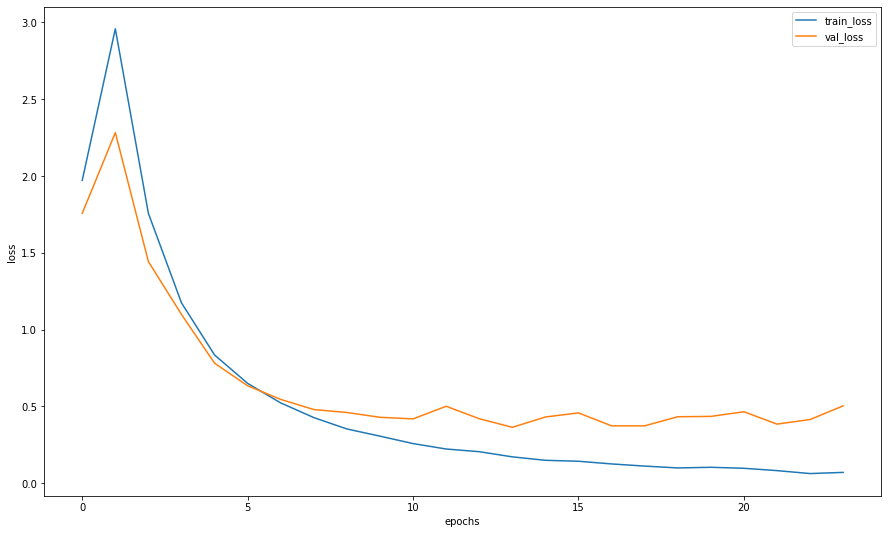

In [13]:
loss, acc, val_loss, val_acc = zip(*history)
plt.figure(figsize=(15, 9))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

In [14]:
model.load_state_dict(torch.load('./my_submit.mdl'))

<All keys matched successfully>

In [15]:
def predict_one_sample(model, inputs, device=DEVICE):
    """Предсказание, для одной картинки"""
    with torch.no_grad():
        inputs = inputs.to(device)
        model.eval()
        logit = model(inputs).cpu()
        probs = torch.nn.functional.softmax(logit, dim=-1).numpy()
    return probs

In [16]:
random_characters = int(np.random.uniform(0,1000))
ex_img, true_label = val_dataset[random_characters]
probs_im = predict_one_sample(model, ex_img.unsqueeze(0))
idxs = list(map(int, np.random.uniform(0,1000, 20)))

imgs = [val_dataset[id][0].unsqueeze(0) for id in idxs]
probs_ims = predict(model, imgs)

label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))

y_pred = np.argmax(probs_ims,-1)
actual_labels = [val_dataset[id][1] for id in idxs]
preds_class = [label_encoder.classes_[i] for i in y_pred]

f1_score(actual_labels, y_pred, average='weighted')

0.8266666666666665

In [17]:
test_dataset = SimpsonsDataset(test_files, mode="test")
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=64)
probs = predict(model, test_loader)

preds = label_encoder.inverse_transform(np.argmax(probs, axis=1))
test_filenames = [path.name for path in test_dataset.files]

my_submit = pd.DataFrame({'Id': test_filenames, 'Expected': preds})
my_submit.to_csv('./my_submit.csv', index=False)
my_submit.head()

,Id,Expected
0,img0.jpg,nelson_muntz
1,img1.jpg,bart_simpson
2,img10.jpg,ned_flanders
3,img100.jpg,chief_wiggum
4,img101.jpg,apu_nahasapeemapetilon
